# Natural Language Processing Disaster Tweets

---



In the context of disaster tweets, NLP plays a crucial role in harnessing the vast amount of real-time information available on platforms like Twitter. The primary objective is to sift through the noise of social media and identify tweets that provide valuable insights into unfolding events, affected areas, and the overall impact of disasters.

Natural Language Processing (NLP) with Disaster Tweets is a field of study and application that involves the use of advanced computational techniques to analyze and understand text data related to disasters shared on social media platforms.

One key aspect of NLP with Disaster Tweets is sentiment analysis, which involves determining the emotional tone conveyed in each tweet. By understanding the sentiment expressed in tweets, emergency responders, government agencies, and humanitarian organizations can gauge the severity of the situation, assess public perception, and tailor their responses accordingly.
Machine learning models, trained on labeled datasets of disaster-related tweets, are commonly used in NLP applications to predict whether a given tweet is relevant to a particular disaster or emergency situation. These models aid in automating the categorization of tweets, allowing for timely and accurate information retrieval.

## Load and Import Data

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install wordcloud
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Conv2D, Reshape, GlobalMaxPooling2D
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from google.colab import files

uploaded = files.upload()

Saving tweets.csv to tweets (1).csv


In [5]:
tweets = pd.read_csv('tweets.csv')

In [6]:
tweets

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


## Exploratory Data Analysis

In [7]:
tweets.describe()

,id,target
count,11370.000000,11370.000000
mean,5684.500000,0.185928
std,3282.380615,0.389066
min,0.000000,0.000000
25%,2842.250000,0.000000
50%,5684.500000,0.000000
75%,8526.750000,0.000000
max,11369.000000,1.000000


In [8]:
tweets.isnull().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

In [9]:
tweets = tweets.dropna()

In [10]:
tweets.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

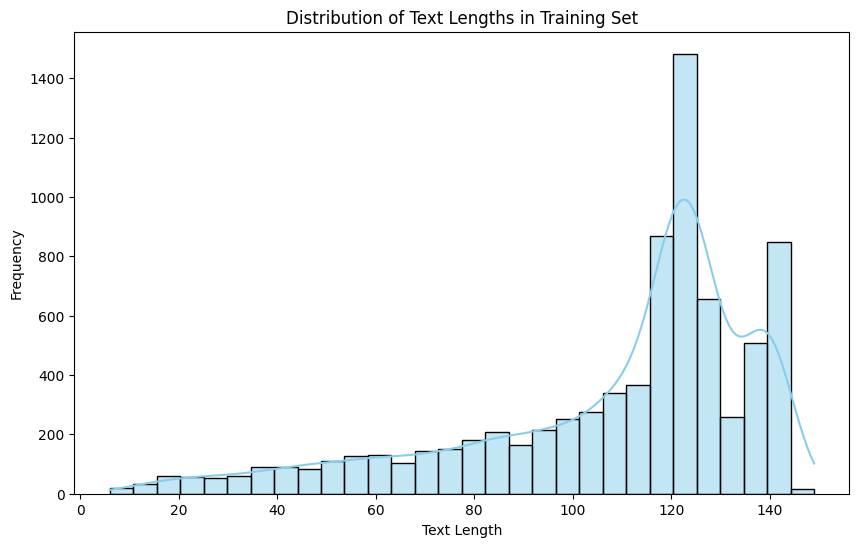

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(tweets['text'].apply(len), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

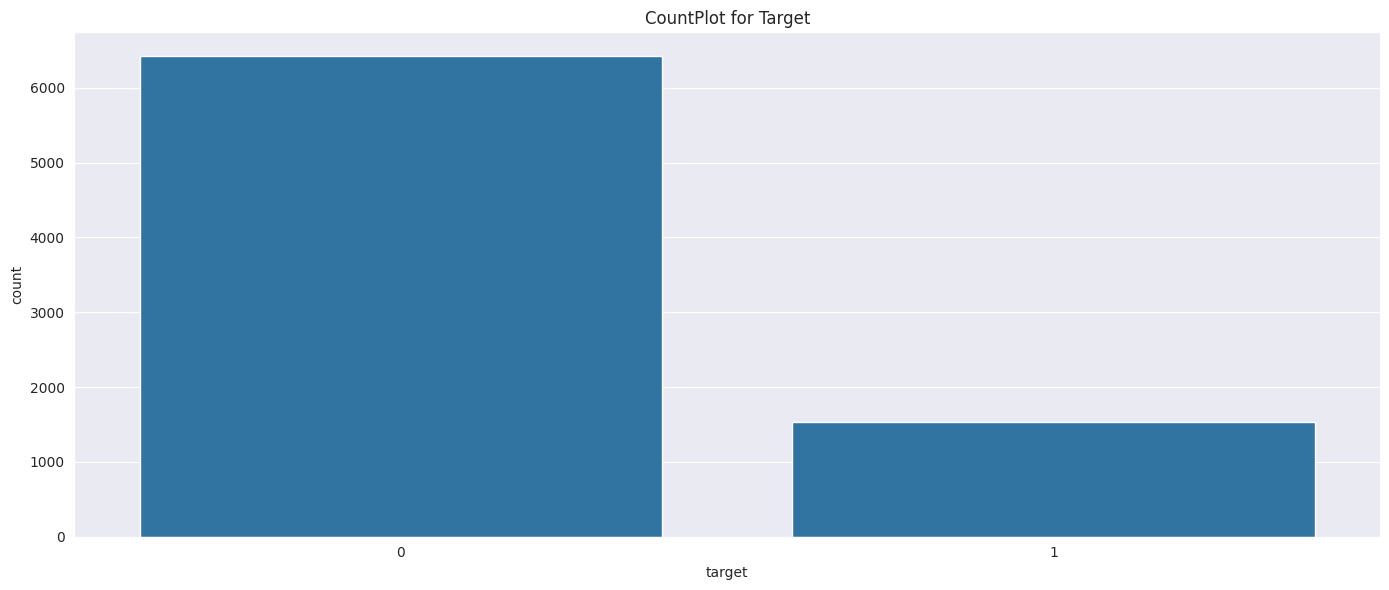

In [12]:
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(data=tweets, x='target')
plt.title('CountPlot for Target')
plt.tight_layout()
plt.show()

In [13]:
def clean_data(data):
  data = data.lower()
  data = re.sub(r'[^a-zA-Z\s]', '', data)
  data = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', data)
  tokens = word_tokenize(data)
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word not in stop_words]

  porter_stemmer = PorterStemmer()
  stemmed_tokens = [porter_stemmer.stem(word) for word in filtered_tokens]

  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
  return stemmed_tokens, lemmatized_tokens

In [14]:
tweets[['stemmed_text', 'lemmatized_text']] = tweets['text'].apply(clean_data).apply(pd.Series)

<ipython-input-14-b1c082cd21a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[['stemmed_text', 'lemmatized_text']] = tweets['text'].apply(clean_data).apply(pd.Series)
<ipython-input-14-b1c082cd21a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[['stemmed_text', 'lemmatized_text']] = tweets['text'].apply(clean_data).apply(pd.Series)


In [15]:
disaster = ''.join(tweets[tweets['target'] == 1]['text'])
non_disaster = ''.join(tweets[tweets['target']==0]['text'])

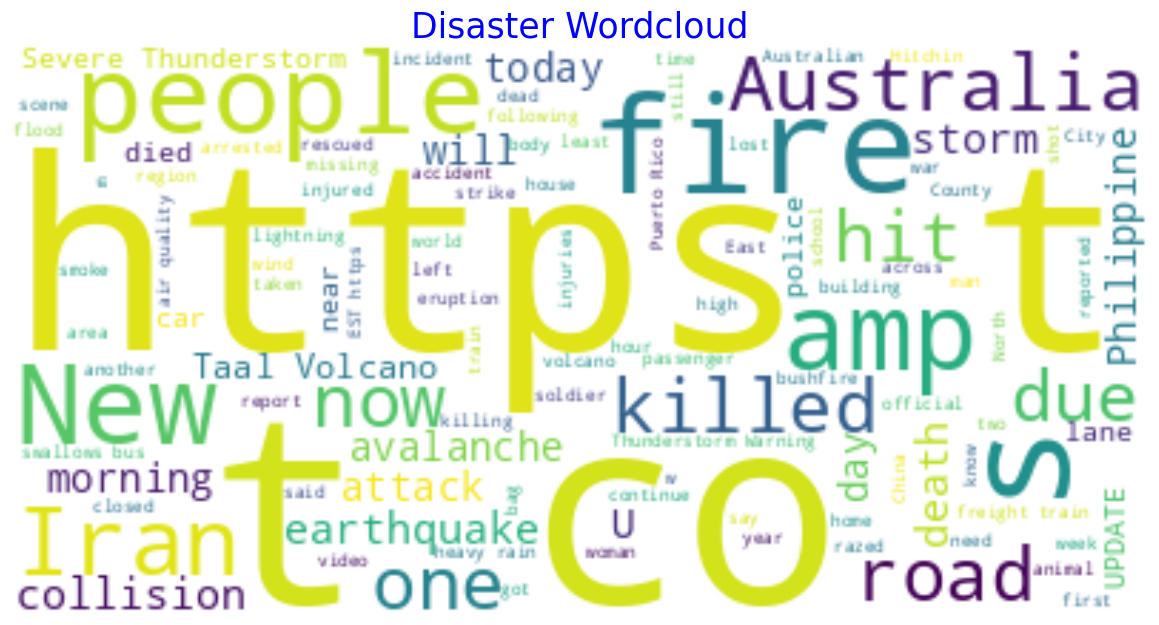

In [16]:
plt.figure(figsize=(14,6))
wordcloud = WordCloud(background_color = 'white').generate(disaster)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Blue')
plt.show()

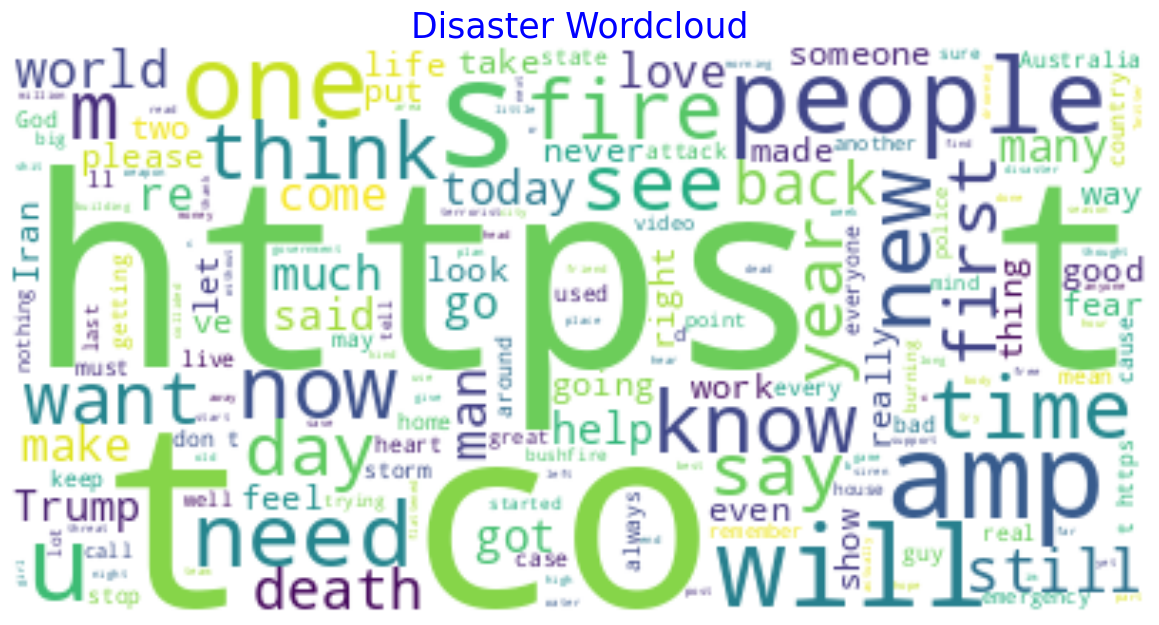

In [17]:
plt.figure(figsize=(14,6))
wordcloud = WordCloud(background_color = 'white').generate(non_disaster)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Blue')
plt.show()

In [18]:
tweets

,id,keyword,location,text,target,stemmed_text,lemmatized_text
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,"[arsonist, set, car, ablaz, dealership, httpst...","[arsonist, set, car, ablaze, dealership, https..."
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,"[arsonist, set, car, ablaz, dealership, httpst...","[arsonist, set, car, ablaze, dealership, https..."
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0,"[child, chines, tweet, would, gone, viral, soc...","[child, chinese, tweet, would, gone, viral, so..."
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1,"[sever, hous, set, ablaz, ngemsibaa, villag, o...","[several, house, set, ablaze, ngemsibaa, villa..."
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1,"[asansol, bjp, offic, salanpur, villag, set, a...","[asansol, bjp, office, salanpur, village, set,..."
...,...,...,...,...,...,...,...
11362,11362,wrecked,feuille d'érable,Stell wrecked ako palagi sayo. Haha. #ALABTopS...,0,"[stell, wreck, ako, palagi, sayo, haha, alabto...","[stell, wrecked, ako, palagi, sayo, haha, alab..."
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,"[media, warn, us, well, advanc, wreck, whole, ...","[medium, warned, u, well, advance, wrecked, wh..."
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,"[feel, directli, attack, consid, moonbin, amp,...","[feel, directly, attacked, consider, moonbin, ..."
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,"[feel, directli, attack, consid, moonbin, amp,...","[feel, directly, attacked, consider, moonbin, ..."



# Model Selection Deep Learning:

For model building, two different types of models are implemented: a Naive Bayes model and a neural network model with both LSTM and Conv1D layers.

### Naive Bayes Model with TF-IDF Vectorization

Multinomial Naive Bayes is commonly used for text classification with discrete features, which aligns with the nature of text data.
TF-IDF vectorization helps represent the importance of words in the documents, capturing key information for classification.

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(tweets['text'], tweets['target'], test_size=0.2, random_state=42)


In [20]:
model = make_pipeline(
    TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english')),
    MultinomialNB()
)

In [21]:
model.fit(train_data, train_labels)

predictions = model.predict(test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [22]:
accuracy = accuracy_score(test_labels, predictions)
classification_rep = classification_report(test_labels, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8321810182275299
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1287
           1       0.97      0.12      0.22       304

    accuracy                           0.83      1591
   macro avg       0.90      0.56      0.56      1591
weighted avg       0.86      0.83      0.78      1591



### LSTM(Long Short-Term Memory) Model

LSTM networks are a type of recurrent neural network (RNN) designed to handle sequences of data, making them suitable for natural language processing tasks.
The Embedding layer is effective in capturing semantic relationships between words in a dense vector space.
LSTM layers are known for their ability to capture long-range dependencies in sequences, which is beneficial for understanding the context in text data.


In [23]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

max_length = 100
train_data_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_data_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [97]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

def create_model_1(learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
model_1 = KerasClassifier(build_fn=create_model_1, learning_rate = 0.001, epochs=5, batch_size=64, verbose=0)
param_grid_1 = {'learning_rate':[0.001, 0.01,0.1],'epochs': [5, 10], 'batch_size': [64, 128]}

In [99]:
grid_search_1 = GridSearchCV(model_1, param_grid_1, cv=2)
grid_search_1.fit(train_data_padded, train_labels_encoded)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=64, build_fn=<function create_model_1 at 0x7ce9e67423b0>, epochs=5, learning_rate=0.001, verbose=0),
             param_grid={'batch_size': [64, 128], 'epochs': [5, 10],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [100]:
best_params_1 = grid_search_1.best_params_

In [101]:
model_1_best = create_model_1()
model_1_best.fit(train_data_padded, train_labels_encoded, epochs=best_params_1['epochs'], batch_size=best_params_1['batch_size'])

Epoch 1/5
100/100 [==============================] - 19s 155ms/step - loss: 0.5023 - accuracy: 0.8071
Epoch 2/5
100/100 [==============================] - 16s 155ms/step - loss: 0.4917 - accuracy: 0.8071
Epoch 3/5
100/100 [==============================] - 16s 156ms/step - loss: 0.4904 - accuracy: 0.8071
Epoch 4/5
100/100 [==============================] - 17s 168ms/step - loss: 0.4918 - accuracy: 0.8071
Epoch 5/5
100/100 [==============================] - 16s 156ms/step - loss: 0.4918 - accuracy: 0.8071


In [102]:
predictions_1 = model_1_best.predict(test_data_padded)
predictions_1 = np.round(predictions_1.flatten()).astype(int)
f1_1 = f1_score(test_labels_encoded, predictions_1)


50/50 [==============================] - 2s 21ms/step


In [103]:
classification_rep_1 = classification_report(test_labels_encoded, predictions_1)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      1287
           1       0.00      0.00      0.00       304

    accuracy                           0.81      1591
   macro avg       0.40      0.50      0.45      1591
weighted avg       0.65      0.81      0.72      1591



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conv1D Neural Network Model

Convolutional Neural Networks (CNNs) with 1D convolutions can effectively capture local patterns and features in sequential data.
The GlobalMaxPooling1D layer helps extract the most relevant features from the convolutional layers.
This architecture is well-suited for tasks where local patterns are important, such as identifying key phrases or patterns in text.

In [86]:
def create_model_3(learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [87]:
model_3 = KerasClassifier(build_fn=create_model_3, learning_rate = 0.001,epochs=5, batch_size=64, verbose=0)

In [88]:
param_grid_3 = {'learning_rate':[0.001, 0.01,0.1],'epochs': [5, 10], 'batch_size': [64, 128]}

In [89]:
grid_search_3 = GridSearchCV(model_3, param_grid_3, cv=2)
grid_search_3.fit(train_data_padded, train_labels_encoded)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=64, build_fn=<function create_model_3 at 0x7ce9f13ee320>, epochs=5, learning_rate=0.001, verbose=0),
             param_grid={'batch_size': [64, 128], 'epochs': [5, 10],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [90]:
best_params_3 = grid_search_3.best_params_

In [91]:
model_3_best = create_model_3()
model_3_best.fit(train_data_padded, train_labels_encoded, epochs=best_params_3['epochs'], batch_size=best_params_3['batch_size'])

Epoch 1/5
100/100 [==============================] - 6s 57ms/step - loss: 0.4902 - accuracy: 0.8071
Epoch 2/5
100/100 [==============================] - 5s 45ms/step - loss: 0.3075 - accuracy: 0.8720
Epoch 3/5
100/100 [==============================] - 5s 47ms/step - loss: 0.1680 - accuracy: 0.9382
Epoch 4/5
100/100 [==============================] - 5s 53ms/step - loss: 0.0862 - accuracy: 0.9739
Epoch 5/5
100/100 [==============================] - 5s 45ms/step - loss: 0.0409 - accuracy: 0.9895


In [92]:
predictions_3 = model_3_best.predict(test_data_padded)
predictions_3 = np.round(predictions_3.flatten()).astype(int)

50/50 [==============================] - 0s 6ms/step


In [93]:
classification_rep_3 = classification_report(test_labels_encoded, predictions_3)

In [95]:
print("Classification Report:\n", classification_rep_3)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1287
           1       0.73      0.66      0.69       304

    accuracy                           0.89      1591
   macro avg       0.83      0.80      0.81      1591
weighted avg       0.89      0.89      0.89      1591



### Results and Analysis

The LSTM model exhibits poor performance, especially for class 1, with zero recall and F1-score. It has accuracy of about 0.81.

The Conv1D model performs relatively well, with higher precision, recall, and F1-score for both classes compared to the LSTM model. The model's accuracy and F1-score for class 1 indicate better performance in identifying disaster-related tweets. Conv1D has better accuracy of 0.89 which is more than the LSTM model


### Conclusion

While the Conv1D model performs better, both models could benefit from hyperparameter tuning and architectural adjustments. Addressing these aspects may lead to improved overall performance in correctly classifying disaster-related tweets.